In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

# Load data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
spam_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/spam.csv', encoding='ISO-8859-1')

if spam_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {spam_df.isna().sum().max()} NAs' )

spam_df = spam_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
spam_df.columns = ['labels', 'data']
spam_df['b_labels'] = spam_df['labels'].map({'ham':0, 'spam':1})

print(spam_df.info())
spam_df.head(10)

df = spam_df.copy()

There are 5566 NAs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    5572 non-null   object
 1   data      5572 non-null   object
 2   b_labels  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB
None


# Preprocess data

In [23]:
Y = df['b_labels'].values
X = df['data'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

print('Example of sentences:')
X_train[0:5]

X_train shape: (3733,)
Y_train shape: (3733,)
X_test shape: (1839,)
Y_test shape: (1839,)
Example of sentences:


array(["How would my ip address test that considering my computer isn't a minecraft server",
       'K..k:)how much does it cost?', 'Going for dinner.msg you after.',
       'You also didnt get na hi hi hi hi hi',
       'Nothing lor... A bit bored too... Then y dun u go home early 2 sleep today...'],
      dtype=object)

In [24]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

word2idx = tokenizer.word_index
V = len(word2idx)
print('Vocabulary size:', V)
print('Tokenized text examples:')
for i in range(3):
  print('\n', X_train[i])
  print(X_train_tokenized[i])

Vocabulary size: 7261
Tokenized text examples:

 How would my ip address test that considering my computer isn't a minecraft server
[53, 206, 11, 3408, 576, 577, 22, 2269, 11, 979, 758, 4, 3409, 3410]

 K..k:)how much does it cost?
[89, 89, 53, 113, 413, 14, 341]

 Going for dinner.msg you after.
[77, 12, 342, 134, 3, 152]


In [30]:
X_train_padded = pad_sequences(X_train_tokenized, padding='pre')
T = X_train_padded.shape[1]
print('Shape of X_train_padded:', X_train_padded.shape)
print('Seqence length T:', T)
X_test_padded = pad_sequences(X_test_tokenized, padding='pre', maxlen=T, truncating='pre')

print('Tokenized and padded text examples:')
for i in range(3):
  print('\n', X_train[i])
  print(X_train_tokenized[i])
  print(X_train_padded[i])

Shape of X_train_padded: (3733, 189)
Seqence length T: 189
Tokenized and padded text examples:

 How would my ip address test that considering my computer isn't a minecraft server
[53, 206, 11, 3408, 576, 577, 22, 2269, 11, 979, 758, 4, 3409, 3410]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

# Build model

In [31]:
D = 20

i = Input(shape=(T,))
x = Embedding(input_dim=(V + 1), output_dim=D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)


model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_padded, Y_train, validation_data=(X_test_padded, Y_test), epochs=10)

Epoch 1/10
117/117 [==============================] - 4s 24ms/step - loss: 0.3975 - accuracy: 0.8661 - val_loss: 0.3009 - val_accuracy: 0.8657
Epoch 2/10
117/117 [==============================] - 3s 22ms/step - loss: 0.1765 - accuracy: 0.9162 - val_loss: 0.1064 - val_accuracy: 0.9608
Epoch 3/10
117/117 [==============================] - 3s 22ms/step - loss: 0.0268 - accuracy: 0.9906 - val_loss: 0.0752 - val_accuracy: 0.9853
Epoch 4/10
117/117 [==============================] - 3s 24ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0827 - val_accuracy: 0.9853
Epoch 5/10
117/117 [==============================] - 3s 28ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0912 - val_accuracy: 0.9837
Epoch 6/10
117/117 [==============================] - 3s 22ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0892 - val_accuracy: 0.9848
Epoch 7/10
117/117 [==============================] - 3s 22ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0906 - val_accuracy: 0.9837

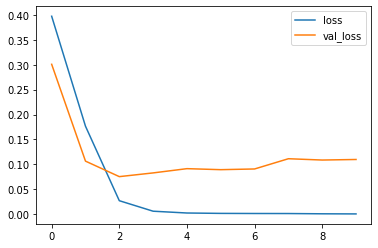

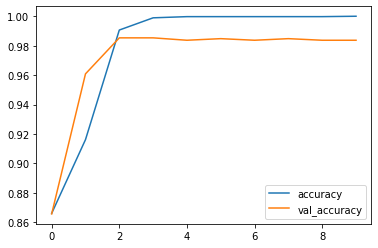

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()